# Taller Final AA3.
    Estudiante: Juan Sebastian Orozco Hernandez
    ID: 1017173516

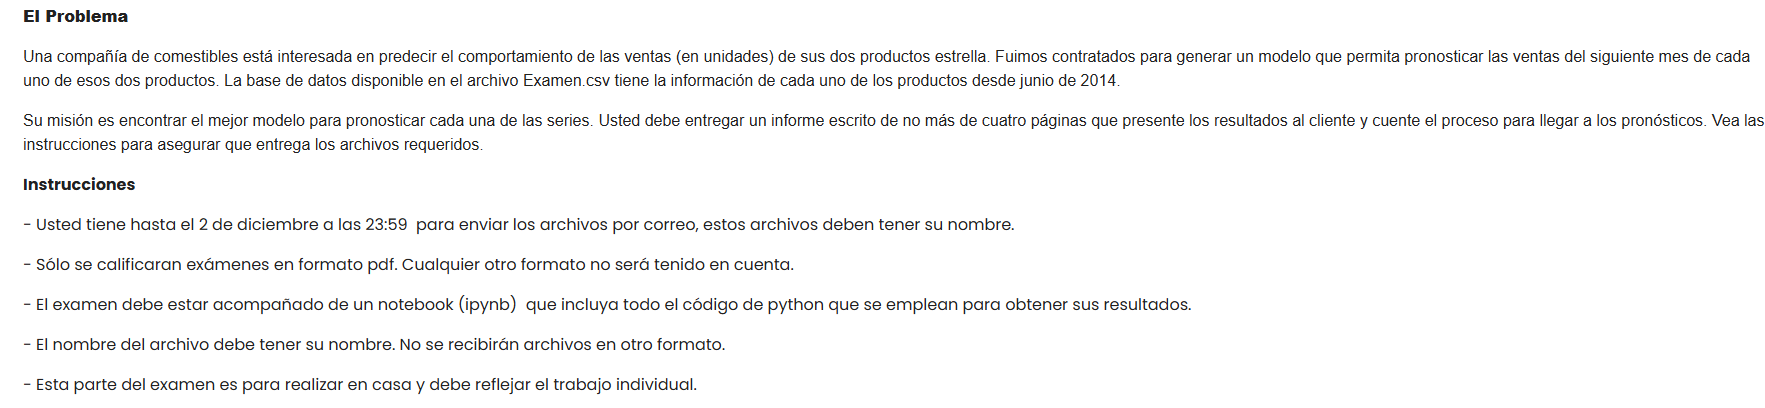

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from pmdarima import auto_arima
import os
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt

## Análisis del dataset Original

In [8]:
main_dir = os.path.dirname(os.getcwd())
inputs_dir = os.path.join(main_dir,"inputs")
outputs_dir = os.path.join(main_dir, "outputs")
html_dir = os.path.join(outputs_dir, "html")
png_dir = os.path.join(outputs_dir, "png")
models_dir = os.path.join(outputs_dir,  "models")
os.makedirs(html_dir, exist_ok=True)
os.makedirs(png_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

In [9]:

#modificar el nombre de la columna index aqui
df_original=pd.read_csv(os.path.join(inputs_dir,'Examen.csv'), parse_dates=True)
df_original
df_original.info


<bound method DataFrame.info of      Unnamed: 0   producto1   producto2
0             1  500.000000  200.000000
1             2  497.400893  210.686220
2             3  478.605317  222.018584
3             4  486.454125  233.920990
4             5  479.695678  238.402098
..          ...         ...         ...
122         123  164.610771  629.293034
123         124  150.881839  637.099467
124         125  151.788470  653.155282
125         126  137.047639  672.528345
126         127  141.990873  676.058092

[127 rows x 3 columns]>

Se observa que la empresa de comestibles tiene un conjunto de datos de 127 meses que inicia desde el mes 06 del 2014 con 3 columnas/caracteristicas con las unidades vendidas de cada uno de los 2 productos por mes.

## Análisis Exploratorio (EDA)

In [10]:
print("\n--- DataFrame Description --- ")
print(df_original.describe())


--- DataFrame Description --- 
       Unnamed: 0   producto1   producto2
count  127.000000  127.000000  127.000000
mean    64.000000  343.571660  581.037664
std     36.805797  100.234821  167.504363
min      1.000000  137.047639  200.000000
25%     32.500000  256.853812  469.194001
50%     64.000000  340.644019  626.048401
75%     95.500000  450.071775  708.941718
max    127.000000  500.000000  806.440615


En el análisis estadístico de las características del dataset, se observa que la primer columna corresponde al mes; para el `producto1` hay un promedio de unidades vendidas de `343.57` con una desviación estandar de `100.23`, el mes que menos se vendió fueron `137.04` unidades y el mes que más se vendió fue de `500` unidades. Así mismo se evaluó el `producto2` donde se observó un promedio de `581` unidades en los `127` meses con una desviación estandar de `167.50`, el mes que menos se vendió fue de `200` unidades y el mes que más vendió fue de `806.44`.

In [11]:

df = df_original.copy()

df["Unnamed: 0"] = pd.date_range(start='2014-06-01', periods=len(df), freq='MS')
df.rename(columns={"Unnamed: 0": "mes"}, inplace=True)
print(df.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   mes        127 non-null    datetime64[ns]
 1   producto1  127 non-null    float64       
 2   producto2  127 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.1 KB
None


In [12]:
df

,mes,producto1,producto2
0,2014-06-01,500.000000,200.000000
1,2014-07-01,497.400893,210.686220
2,2014-08-01,478.605317,222.018584
3,2014-09-01,486.454125,233.920990
4,2014-10-01,479.695678,238.402098
...,...,...,...
122,2024-08-01,164.610771,629.293034
123,2024-09-01,150.881839,637.099467
124,2024-10-01,151.788470,653.155282
125,2024-11-01,137.047639,672.528345


## Funciones de visualización de las series de tiempo y su descomposición

In [13]:
def plot_time_series(
    df,
    date_col,
    value_col,
    x_label="Fecha",
    y_label="Valor",
    title="Serie Temporal",
    html_path="eda.html",
    png_path="eda.png"
):

    df[date_col] = pd.to_datetime(df[date_col])
    serie = df.set_index(date_col)[value_col]

    media_val = serie.mean()
    min_val = serie.min()
    max_val = serie.max()
    min_date = serie.idxmin()
    max_date = serie.idxmax()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=serie.index, y=serie, mode="lines", name=value_col))
    fig.add_trace(go.Scatter(
        x=serie.index, y=[media_val]*len(serie),
        mode="lines", name=f"Media {media_val:.2f}", line=dict(dash="dot")
    ))
    fig.add_trace(go.Scatter(x=[min_date], y=[min_val], mode="markers",
                             marker=dict(size=10, color="red"), name="Mínimo"))
    fig.add_trace(go.Scatter(x=[max_date], y=[max_val], mode="markers",
                             marker=dict(size=10, color="green"), name="Máximo"))
    fig.update_layout(title=title, xaxis_title=x_label, yaxis_title=y_label,
                      paper_bgcolor="white", plot_bgcolor="white")
    fig.write_html(html_path)
    plt.figure(figsize=(12,6))
    plt.plot(serie.index, serie.values, label=value_col, color="blue")
    plt.axhline(media_val, linestyle="--", color="orange", label=f"Media {media_val:.2f}")
    plt.scatter(min_date, min_val, color="red", s=70, label=f"Mínimo {min_val:.2f}")
    plt.scatter(max_date, max_val, color="green", s=70, label=f"Máximo {max_val:.2f}")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path, dpi=300)
    plt.close()

    return fig

def seasonal_decomposition(
    df,
    date_col,
    value_col,
    model="additive",
    period=None,
    title="Seasonal Decomposition",
    html_path="seasonal_decomposition.html",
    png_path="seasonal_decomposition.png"
):

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)

    result = seasonal_decompose(df[value_col], model=model, period=period)
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=["Serie Original", "Tendencia", "Estacionalidad", "Residuo"]
    )
    fig.add_trace(go.Scatter(x=df.index, y=result.observed, mode="lines"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=result.trend, mode="lines"), row=1, col=2)
    fig.add_trace(go.Scatter(x=df.index, y=result.seasonal, mode="lines"), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=result.resid, mode="lines"), row=2, col=2)

    fig.update_layout(title=title, height=900, width=1300,
                      paper_bgcolor="white", plot_bgcolor="white")
    fig.write_html(html_path)
    plt.figure(figsize=(14,10))

    plt.subplot(2,2,1)
    plt.plot(df.index, result.observed, color="blue")
    plt.title("Serie Original")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(2,2,2)
    plt.plot(df.index, result.trend, color="orange")
    plt.title("Tendencia")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(2,2,3)
    plt.plot(df.index, result.seasonal, color="green")
    plt.title("Estacionalidad")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(2,2,4)
    plt.plot(df.index, result.resid, color="red")
    plt.title("Residuo")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(png_path, dpi=300)
    plt.close()

    return fig

## EDA para el producto 1 y su comportamiento a través del tiempo

In [14]:
# Se grafica la serie temporal de la columna "producto1"
plot_time_series(
    df=df,
    date_col="mes",
    value_col="producto1",
    x_label="Fecha",
    y_label="Producto1",
    title="",
    html_path=os.path.join(html_dir, "EDA_Producto1.html"),png_path=os.path.join(html_dir, "EDA_Producto1.png")
)

In [15]:
seasonal_decomposition(
    df=df,
    date_col="mes",
    value_col="producto1",
    model="additive",
    period=12,
    html_path=os.path.join(html_dir, "seasonal_decompose_Producto1.html"),
    png_path=os.path.join(png_dir, "seasonal_decompose_Producto1.png"),title=''
)

Se observa que la serie del producto 1 presenta una tendencia general decreciente, aunque con un repunte temporal entre 2021 y 2022.

En cuanto a la estacionalidad, esta muestra un patrón cíclico anual que inicia su ascenso en mayo hasta alcanzar su máximo global en julio. Posteriormente, decrece hasta diciembre. A inicios de año, se observa una leve recuperación en enero seguida de una caída hasta marzo, para repuntar brevemente en abril antes de volver a bajar en mayo.

In [16]:
def optimize_ets_mw(df, date_col, value_col,
                    initial_train_size=48,
                    forecast_horizon=6,
                    step_size=6):
    series = df[value_col]
    n = len(series)

    errors    = [None,"additive", "multiplicative"]
    trends    = [None, "additive", "multiplicative"]
    seasonals = [None, "additive", "multiplicative"]

    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    results = {}

    for error in errors:
        for trend in trends:
            for seasonal in seasonals:

                rmses = []

                for start in range(0, 
                                   n - initial_train_size - forecast_horizon + 1, 
                                   step_size):

                    train = series.iloc[start:start + initial_train_size].values
                    test  = series.iloc[start + initial_train_size:
                                        start + initial_train_size + forecast_horizon].values

                    try:
                        model = ETSModel(
                            endog=train,
                            error=error,
                            trend=trend,
                            seasonal=seasonal
                        ).fit()

                        pred = model.forecast(forecast_horizon)

                    except:
                        rmses.append(np.nan)
                        continue

                    if (np.any(np.isnan(pred)) or 
                        np.any(np.isinf(pred)) or
                        np.any(np.abs(pred) > 1e10)):
                        rmses.append(np.nan)
                    else:
                        rmses.append(rmse(test, pred))
                valid_rmses = [x for x in rmses if not np.isnan(x)]
                avg_rmse = np.mean(valid_rmses) if valid_rmses else np.inf

                results[(error, trend, seasonal)] = avg_rmse

    best = min(results, key=results.get)
    best_rmse = results[best]

    return {
        "best_params": {
            "error": best[0],
            "trend": best[1],
            "seasonal": best[2]
        },
        "best_rmse": best_rmse,
        "all_results": results
    }
def rolling_ets_results(df, date_col, value_col, params,
                        initial_train_size,
                        forecast_horizon,
                        step_size):
    series = df[value_col]
    n = len(series)

    metrics = []

    error = params["error"]
    trend = params["trend"]
    seasonal = params["seasonal"]

    for start in range(0, n - initial_train_size - forecast_horizon + 1, step_size):

        train = series.iloc[start:start + initial_train_size].values
        test  = series.iloc[start + initial_train_size:
                            start + initial_train_size + forecast_horizon].values

        window_start = series.index[start]
        window_end   = series.index[start + initial_train_size - 1]

        try:
            model = ETSModel(
                endog=train,
                error=error,
                trend=trend,
                seasonal=seasonal
            ).fit()

            pred = model.forecast(forecast_horizon)

            rmse = np.sqrt(mean_squared_error(test, pred))

        except:
            rmse = np.nan

        metrics.append({
            "window_start": window_start,
            "window_end": window_end,
            "rmse": rmse
        })

    return pd.DataFrame(metrics)
def plot_ets_rmse_interactive(results_df, html_path="ets_rmse.html", png_path="ets_rmse.png"):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=results_df["window_end"],
        y=results_df["rmse"],
        mode="lines+markers",
        marker=dict(size=8),
        line=dict(width=2),
        name="RMSE"
    ))

    fig.update_layout(
        title="RMSE por ventana móvil (ETS - mejor modelo)",
        xaxis_title="Fin de ventana de entrenamiento",
        yaxis_title="RMSE",
        template="plotly_white",
        width=1000,
        height=600
    )

    fig.write_html(html_path)
    fig.write_image(png_path)

    fig.show()

## EDA para el producto 2 y su comportamiento a través del tiempo

In [17]:
# Se grafica la serie temporal de la columna "producto2"
plot_time_series(
    df=df,
    date_col="mes",
    value_col="producto2",
    x_label="Fecha",
    y_label="producto2",
    title="",
    html_path=os.path.join(html_dir, "EDA_producto2.html"),png_path=os.path.join(html_dir, "EDA_producto2.png")
)

In [18]:
seasonal_decomposition(
    df=df,
    date_col="mes",
    value_col="producto2",
    model="additive",
    period=12,
    html_path=os.path.join(html_dir, "seasonal_decompose_Producto2.html"),
    png_path=os.path.join(png_dir, "seasonal_decompose_Producto2.png"),title=''
)